# Experiments with Zee

* This notebook contains code for experiments with Zee for WiFi radio map construction.

## Imports & Utilities

In [1]:
import sys
import os

# Add paths for resolve 
INDOOR_COMPETITION_20_DIR = os.path.join("..", "indoor-location-competition-20")
sys.path.append(INDOOR_COMPETITION_20_DIR)
CODE_DIR = ".."
sys.path.append(CODE_DIR)

In [2]:
import numpy as np
import pandas as pd
import json
import shapely
import sklearn
import scipy
import shapely.vectorized
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon
from shapely import ops as shapely_ops

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from dataclasses import dataclass, field
from multiprocessing import Pool

%matplotlib inline
from py_indoor_loc.model import read_data_file
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries, scale
from py_indoor_loc.sensors import compute_earth_acce_heading_ahrs
from py_indoor_loc.utils import rotate, inverse_rotate
from pathlib import Path
from glob import glob
from py_indoor_loc.floor_map import transform_rotation
from compute_f import compute_step_positions
from py_indoor_loc.zee import create_search_grid, SearchGrid
from py_indoor_loc.zee import estimate_heading_offset, init_apf, run_apf
from py_indoor_loc.floor_map import inverse_scale

In [3]:
data_dir = Path(f"../../data/train")
metadata_dir = Path(f"../../data/metadata")

In [4]:
def create_track_waypoints(sensor_ts: np.ndarray, history) -> pd.DataFrame:
  track_waypoints = []

  for step in history:
    step_point = step.particles[step.keep_mask, :2].mean(axis=0).tolist()
    step_time = sensor_ts[step.sample_index]
    track_waypoints.append((step_time, *step_point))

  return pd.DataFrame(track_waypoints, columns=["sys_ts", "x", "y"])

In [5]:
def interpolate_wifi_waypoints(waypoint_df: pd.DataFrame,
                               track_wifi_df: pd.DataFrame,
                               max_offset_sec: int = 2) -> pd.DataFrame:
  """
  Interpolation Rules:
  - For points with timestamps near the start and end waypoints, assign the locations of start/end waypoints to these points.
  - For points with timestamps between those of start and end waypoints, linear interpolate locations of these points.

  Params:
    waypoint_df: a pd.DataFrame represents waypoints
    track_wifi_df: a pd.DataFrame represents wifi fingerprints
    max_offset_sec: maximum offset in seconds

  Returns: a pd.DataFrame of wifi waypoints
  """
  assert "sys_ts" in waypoint_df.columns
  assert "sys_ts" in track_wifi_df.columns

  max_offset_millis = max_offset_sec * 1000

  waypoint_ts = waypoint_df["sys_ts"].values
  waypoint_x, waypoint_y = waypoint_df["x"].values, waypoint_df["y"].values

  wifi_ts = track_wifi_df["sys_ts"].unique()

  interpolated_x = np.ones_like(wifi_ts, dtype=np.float32) * -1
  interpolated_y = np.ones_like(wifi_ts, dtype=np.float32) * -1

  # Points near the left pivot
  left_pivot_mask = (wifi_ts <= waypoint_ts[0]) & (waypoint_ts[0] - wifi_ts
                                                   <= max_offset_millis)
  interpolated_x[left_pivot_mask] = waypoint_x[0]
  interpolated_y[left_pivot_mask] = waypoint_y[0]

  # Points near the right pivot
  right_pivot_mask = (wifi_ts > waypoint_ts[-1]) & (wifi_ts - waypoint_ts[-1]
                                                    <= max_offset_millis)
  interpolated_x[right_pivot_mask] = waypoint_x[-1]
  interpolated_y[right_pivot_mask] = waypoint_y[-1]

  # Inner points: waypoint_ts[left_idx] < wifi_ts <= waypoint_ts[right_idx]
  right_idx = np.searchsorted(waypoint_ts, wifi_ts, side="left")
  left_idx = right_idx - 1
  inner_mask = (right_idx > 0) & (right_idx < len(waypoint_ts))
  prev_waypoint_ts, next_waypoint_ts = waypoint_ts[
      left_idx[inner_mask]], waypoint_ts[right_idx[inner_mask]]
  frac = (wifi_ts[inner_mask] - prev_waypoint_ts) / (next_waypoint_ts -
                                                     prev_waypoint_ts)
  interpolated_x[inner_mask] = waypoint_x[left_idx[inner_mask]] + frac * (
      waypoint_x[right_idx[inner_mask]] - waypoint_x[left_idx[inner_mask]])
  interpolated_y[inner_mask] = waypoint_y[left_idx[inner_mask]] + frac * (
      waypoint_y[right_idx[inner_mask]] - waypoint_y[left_idx[inner_mask]])

  keep_mask = interpolated_x != -1
  wifi_waypoint_df = pd.DataFrame(np.vstack([
      wifi_ts[keep_mask], interpolated_x[keep_mask], interpolated_y[keep_mask]
  ]).T,
                                  columns=["sys_ts", "x", "y"])

  return wifi_waypoint_df


def extract_wifi_df(wifi: np.ndarray, verbose=False):
  wifi_schema = {
      "sys_ts":
          "system timestamp",
      "ssid":
          "the network name",
      "bssid":
          "the MAC address of the AP",
      "rssi":
          "RSSI",
      "freq":
          "Frequency",
      "last_seen_ts":
          "timestamp in microseconds (since boot) when this result was last seen"
  }
  wifi_df = pd.DataFrame(wifi, columns=list(wifi_schema.keys()))
  wifi_df["bssid"] = wifi_df["bssid"].astype("category")
  wifi_df["ssid"] = wifi_df["ssid"].astype("category")
  wifi_df["sys_ts"] = wifi_df["sys_ts"].astype(np.int64)
  wifi_df["last_seen_ts"] = wifi_df["last_seen_ts"].astype(np.int64)
  wifi_df["rssi"] = wifi_df["rssi"].astype(np.int32)
  wifi_df["freq"] = wifi_df["freq"].astype(np.int32)

  if verbose:
    print(
        f"Summary stats: n_samples={wifi_df.shape[0]}, n_seen_bssid={wifi_df.bssid.unique().shape[0]}, n_seen_ssid={wifi_df.ssid.unique().shape[0]}"
    )
  return wifi_df


def extract_waypoint_df(waypoint_array: np.ndarray, verbose=False):
  waypoint_schema = {
      "sys_ts": "System timestamp",
      "x": "Coordinate x (meter)",
      "y": "Coordinate y (meter)"
  }

  assert waypoint_array.shape[
      1] == 3, f"invalid shape, expected: (?, 3), actual: (?, {waypoint_array.shape[1]})"

  waypoint_df = pd.DataFrame(waypoint_array,
                             columns=list(waypoint_schema.keys()))
  waypoint_df["sys_ts"] = waypoint_df["sys_ts"].astype(np.int64)
  waypoint_df["x"] = waypoint_df["x"].astype(np.float32)
  waypoint_df["y"] = waypoint_df["y"].astype(np.float32)
  waypoint_df.sort_values(by="sys_ts", inplace=True)

  if verbose:
    sys_time_diff = (waypoint_df["sys_ts"].values[1:] -
                     waypoint_df["sys_ts"].values[:-1]) / 1000
    print(
        f"Summary stats: n_samples={waypoint_df.shape[0]}, mean={sys_time_diff.mean():.2f}s, std={sys_time_diff.std():.2f}s"
    )

  return waypoint_df


## Test Scenario 1 & 2

In [6]:
experiment_tracks = pd.read_csv("./setup/experiment_tracks.csv")

In [7]:
experiment_tracks["site_id"].unique().shape[0]

8

In [10]:
site_floors = experiment_tracks[["site_id", "floor_id"]].drop_duplicates().values

In [12]:
site_id, floor_id = site_floors[1]

In [13]:
site_floor_experiment_tracks = experiment_tracks.loc[
    (experiment_tracks["site_id"] == site_id) &
    (experiment_tracks["floor_id"] == floor_id)]

print("The number of tracks is:", site_floor_experiment_tracks.shape[0])

track_files = [
  data_dir / site_id / floor_id / (track_id + ".txt")
  for site_id, floor_id, track_id in site_floor_experiment_tracks[["site_id", "floor_id", "track_id"]].values
]

The number of tracks is: 162


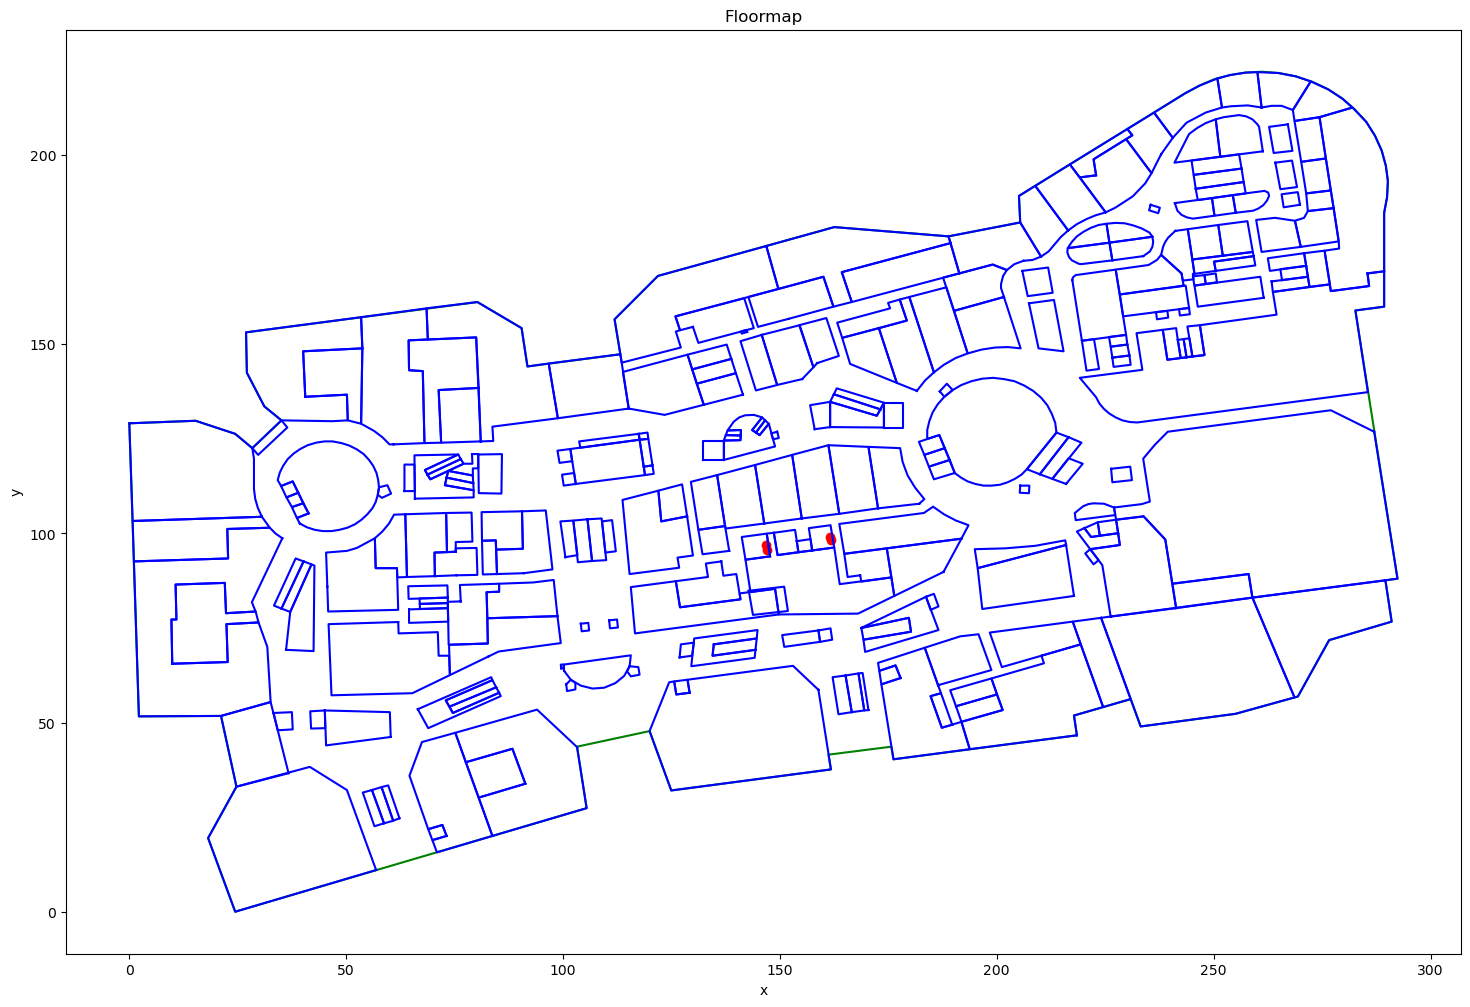

In [14]:
floor_info, floor_map = read_floor_data(str(metadata_dir / site_id / floor_id))

(
    floor_polygons,
    store_polygons,
    x_min,
    y_min,
    x_max,
    y_max,
    width_meter,
    height_meter,
) = extract_floor_map_geometries(floor_map,
                                 floor_info)

fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green", label="floor")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue", label="store")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

# Adding ground-truth location
path_data_collection = read_data_file(track_files[100])
ax.scatter(path_data_collection.waypoint[:, 1], path_data_collection.waypoint[:, 2], marker="o", color="red")

plt.ticklabel_format(useOffset=False)
plt.show()

In [15]:
search_grid = create_search_grid(floor_polygons,
                                 store_polygons,
                                 width_meter,
                                 height_meter,
                                 grid_resolution=3.0,
                                 tol=1.0)


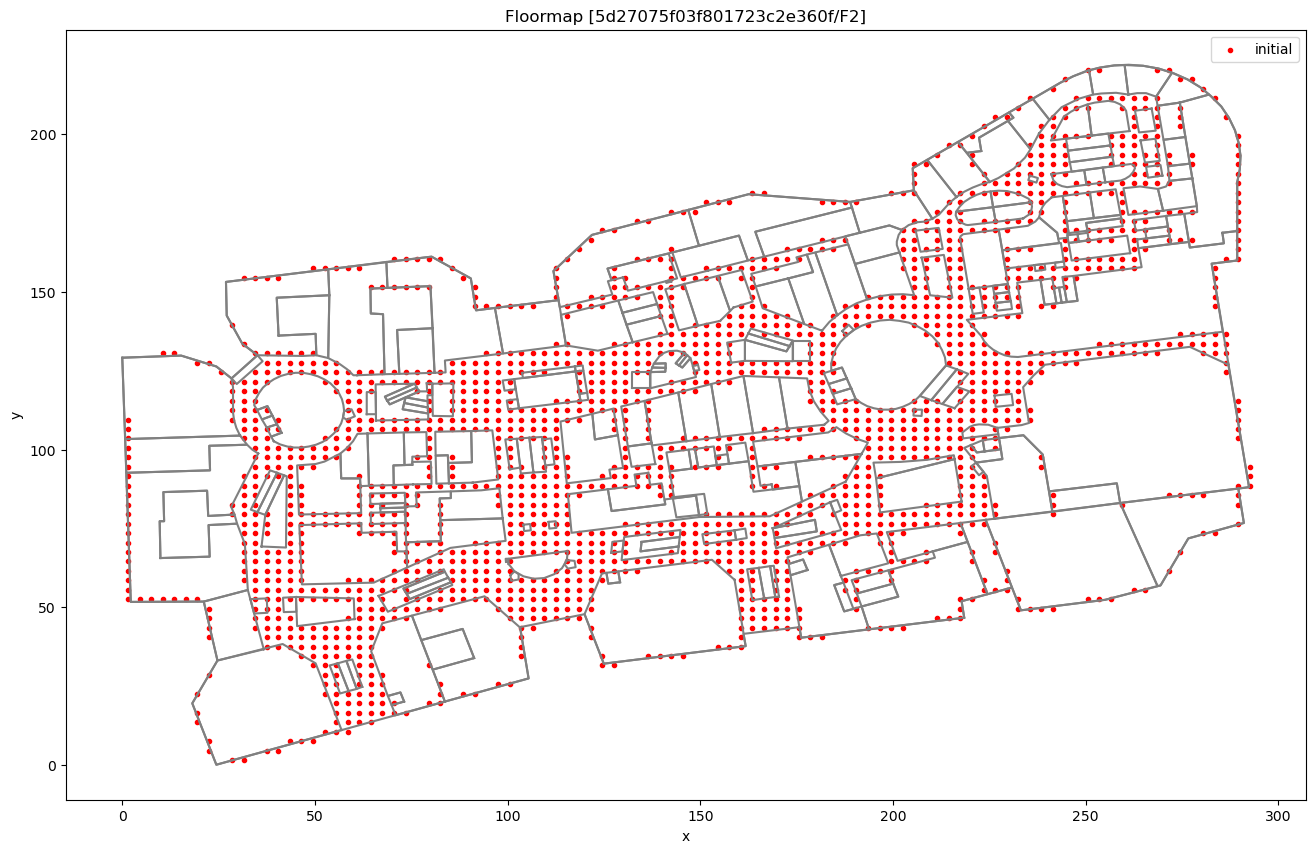

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="gray")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="gray")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Floormap [{site_id}/{floor_id}]")

# Adding search grid
ax.scatter(search_grid.grid_points[:, 0],
           search_grid.grid_points[:, 1],
           marker=".",
           color="red",
           label="initial")

ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

In [17]:
path_data_collection = read_data_file(track_files[100])

In [18]:
earth_acce_arr, earth_heading_arr = compute_earth_acce_heading_ahrs(
    sensor_acce=path_data_collection.acce,
    sensor_ahrs=path_data_collection.ahrs)


### Experiment: Without Prior Knowledge about the Initial Location

In [19]:
heading_offset = estimate_heading_offset(earth_acce_arr[:50], fs=50)
alpha = heading_offset -  earth_heading_arr[:50].mean()

initial_particles = init_apf(search_grid, placement_offset_center=alpha, placement_offset_loc=0.1, n_particles=10000)
history = run_apf(earth_acce_arr, earth_heading_arr, initial_particles, search_grid, verbose=False)

track_waypoints_df = create_track_waypoints(path_data_collection.acce[:, 0], history)

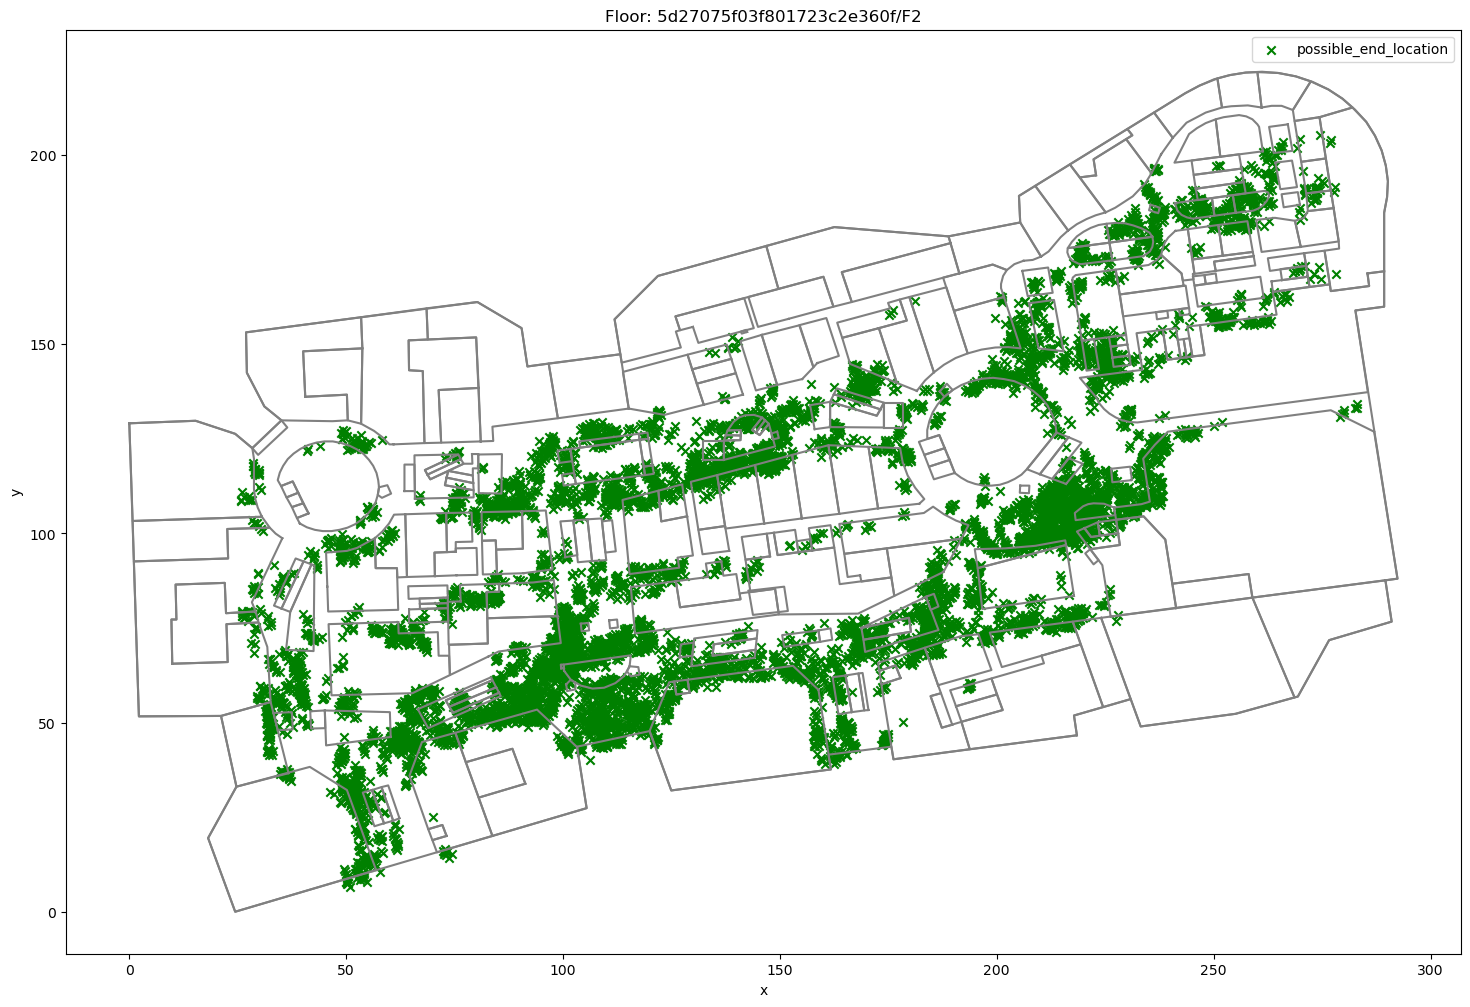

In [20]:
(
    floor_polygons,
    store_polygons,
    x_min,
    y_min,
    x_max,
    y_max,
    width_meter,
    height_meter,
) = extract_floor_map_geometries(floor_map, floor_info)

fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="gray")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="gray")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Floor: {site_id}/{floor_id}")

# Adding ground-truth location
# ax.plot(path_data_collection.waypoint[:, 1], path_data_collection.waypoint[:, 2], marker="^", color="red", label="track")
# ax.plot(track_waypoints_df["x"].values, track_waypoints_df["y"].values, marker="o", color="blue")
ax.scatter(history[-1].particles[:, 0], history[-1].particles[:, 1], marker="x", color="green", label="possible_end_location")
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

### Experiment: Prior Knowledge about the Initial Location

* We assume that the initial location is distributed randomly according to uniform distribution around 10m of the initial waypoint.
* In real-world systems, the distribution of initial location can be estimated by WiFi fingerprinting methods.

In [21]:
heading_offset = estimate_heading_offset(earth_acce_arr[:50], fs=50)
alpha = heading_offset - earth_heading_arr[:50].mean()

initial_particles = init_apf(search_grid,
                             placement_offset_center=alpha,
                             placement_offset_loc=0.1,
                             n_particles=10000,
                             initial_location_center=tuple(path_data_collection.waypoint[0, 1:]))
history = run_apf(earth_acce_arr,
                  earth_heading_arr,
                  initial_particles,
                  search_grid,
                  verbose=False)

track_waypoints_df = create_track_waypoints(path_data_collection.acce[:, 0],
                                            history)


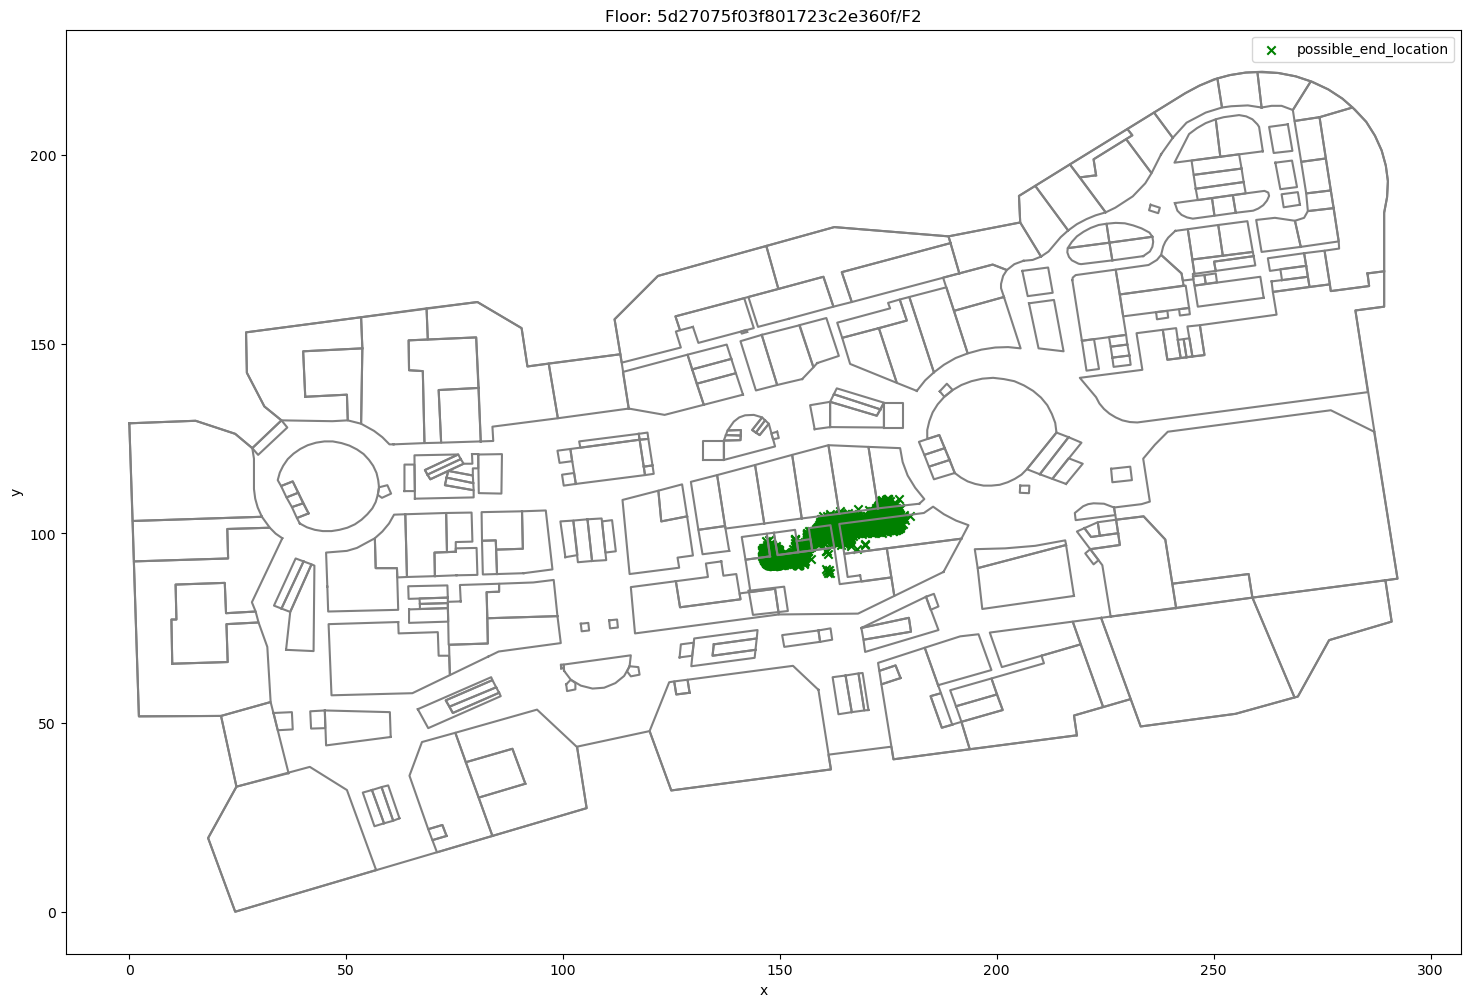

In [22]:
(
    floor_polygons,
    store_polygons,
    x_min,
    y_min,
    x_max,
    y_max,
    width_meter,
    height_meter,
) = extract_floor_map_geometries(floor_map, floor_info)

fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="gray")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="gray")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Floor: {site_id}/{floor_id}")

# Adding ground-truth location
# ax.plot(path_data_collection.waypoint[:, 1], path_data_collection.waypoint[:, 2], marker="^", color="red", label="track")
# ax.plot(track_waypoints_df["x"].values, track_waypoints_df["y"].values, marker="o", color="blue")
ax.scatter(history[-1].particles[:, 0], history[-1].particles[:, 1], marker="x", color="green", label="possible_end_location")
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

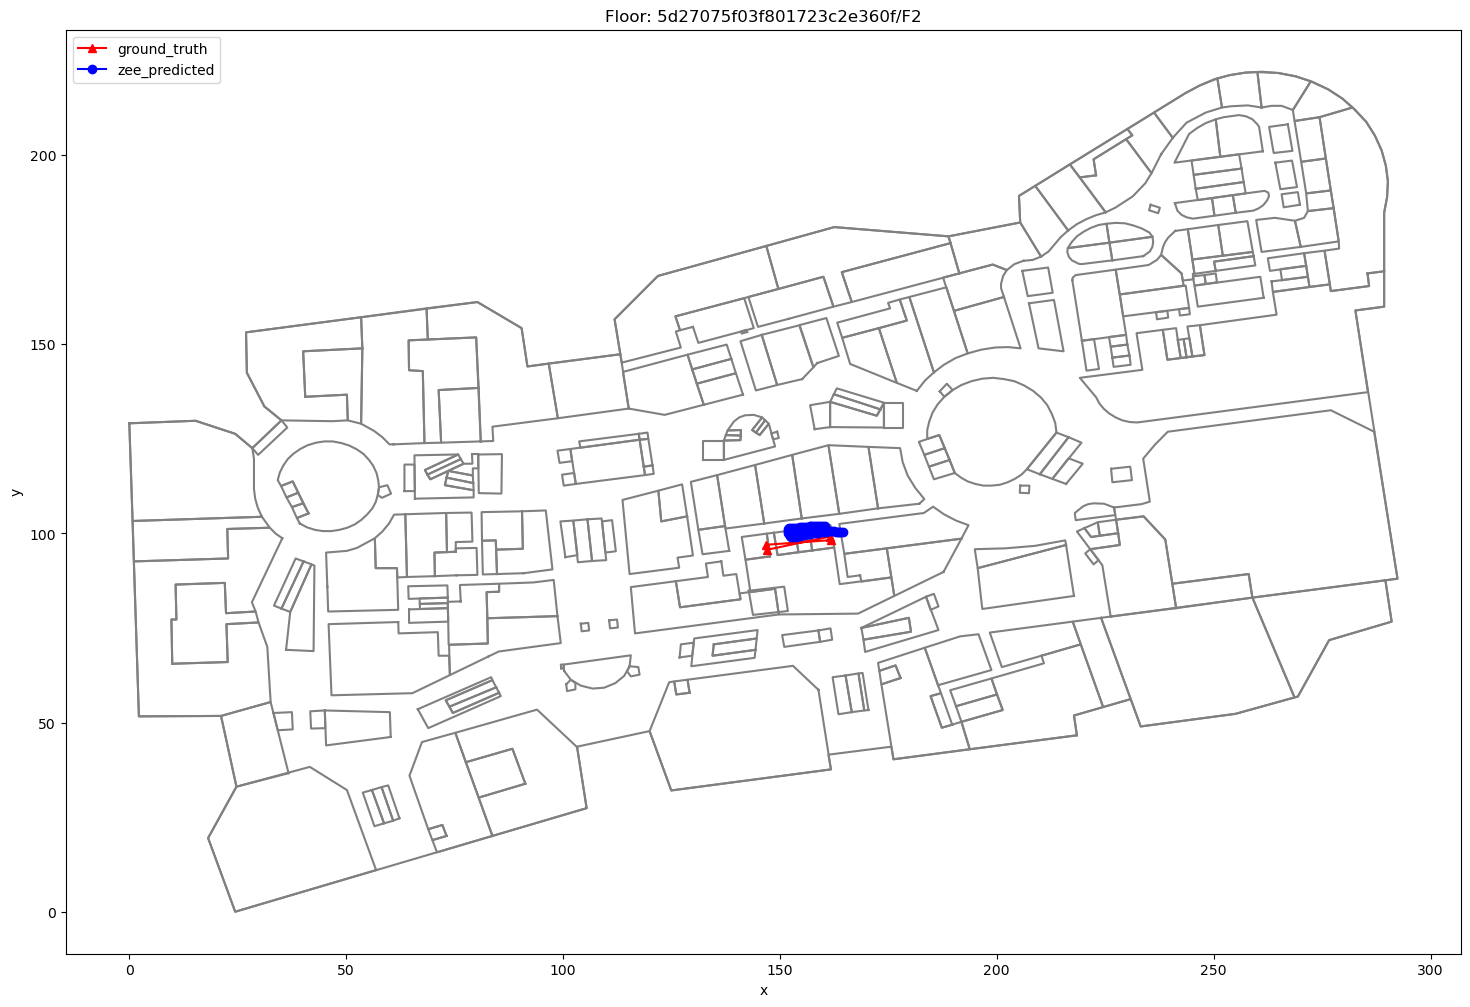

In [23]:
(
    floor_polygons,
    store_polygons,
    x_min,
    y_min,
    x_max,
    y_max,
    width_meter,
    height_meter,
) = extract_floor_map_geometries(floor_map, floor_info)

fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="gray")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="gray")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Floor: {site_id}/{floor_id}")

# Adding ground-truth location
ax.plot(path_data_collection.waypoint[:, 1], path_data_collection.waypoint[:, 2], marker="^", color="red", label="ground_truth")
ax.plot(track_waypoints_df["x"].values, track_waypoints_df["y"].values, marker="o", color="blue", label="zee_predicted")
# ax.scatter(history[-1].particles[:, 0], history[-1].particles[:, 1], marker="x", color="green", label="possible_end_location")
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

### Running Experiments on Multiple Tracks

* Scenario 1: Running Zee without any knowledge about the initial locations of tracks

In [24]:
def run_zee_experiment_no_initial_location(site_id: str, floor_id: str):
  print(f"Running Zee experiments for {site_id}/{floor_id}")

  site_floor_experiment_tracks = experiment_tracks.loc[
      (experiment_tracks["site_id"] == site_id) &
      (experiment_tracks["floor_id"] == floor_id)]

  print("The number of tracks is:", site_floor_experiment_tracks.shape[0])

  track_files = [
      data_dir / site_id / floor_id / (track_id + ".txt")
      for site_id, floor_id, track_id in site_floor_experiment_tracks[
          ["site_id", "floor_id", "track_id"]].values
  ]

  floor_info, floor_map = read_floor_data(str(metadata_dir / site_id /
                                              floor_id))

  (
      floor_polygons,
      store_polygons,
      x_min,
      y_min,
      x_max,
      y_max,
      width_meter,
      height_meter,
  ) = extract_floor_map_geometries(floor_map, floor_info)

  search_grid = create_search_grid(floor_polygons,
                                   store_polygons,
                                   width_meter,
                                   height_meter,
                                   grid_resolution=3.0,
                                   tol=1.0)

  for train_file in tqdm(track_files):
    path_data_collection = read_data_file(train_file)
    earth_acce_arr, earth_heading_arr = compute_earth_acce_heading_ahrs(
        path_data_collection.acce, path_data_collection.ahrs)
    heading_offset = estimate_heading_offset(earth_acce_arr[:50], fs=50)
    alpha = heading_offset - earth_heading_arr[:50].mean()
    initial_particles = init_apf(search_grid, placement_offset_center=alpha, n_particles=10000)
    history = run_apf(earth_acce_arr,
                      earth_heading_arr,
                      initial_particles,
                      search_grid,
                      verbose=False)

    track_waypoints_df = create_track_waypoints(path_data_collection.acce[:, 0],
                                                history)

    track_name = os.path.basename(train_file)[:-len(".txt")]
    os.makedirs(f"../../data/zee_scene_1/train/{site_id}/{floor_id}/",
                exist_ok=True)
    track_waypoints_df.to_csv(
        f"../../data/zee_scene_1/train/{site_id}/{floor_id}/{track_name}_waypoint.csv",
        index=False,
        header=True)


In [60]:
for site_id, floor_id in site_floors[2:]:
  run_zee_experiment_no_initial_location(site_id, floor_id)

Running Zee experiments for 5d2709b303f801723c327472/1F
The number of tracks is: 135


  0%|          | 0/135 [00:00<?, ?it/s]

  4%|▎         | 5/135 [00:21<08:39,  4.00s/it]

* Scenario 2: Running Zee with prior knowledge about the initial location

In [26]:
def run_zee_experiment_with_initial_location(site_id: str, floor_id: str,
                                             save_output_dir: str):
  print(f"Running Zee experiments for {site_id}/{floor_id}")

  site_floor_experiment_tracks = experiment_tracks.loc[
      (experiment_tracks["site_id"] == site_id) &
      (experiment_tracks["floor_id"] == floor_id)]

  print("The number of tracks is:", site_floor_experiment_tracks.shape[0])

  track_files = [
      data_dir / site_id / floor_id / (track_id + ".txt")
      for site_id, floor_id, track_id in site_floor_experiment_tracks[
          ["site_id", "floor_id", "track_id"]].values
  ]

  floor_info, floor_map = read_floor_data(str(metadata_dir / site_id /
                                              floor_id))

  (
      floor_polygons,
      store_polygons,
      x_min,
      y_min,
      x_max,
      y_max,
      width_meter,
      height_meter,
  ) = extract_floor_map_geometries(floor_map, floor_info)

  search_grid = create_search_grid(floor_polygons,
                                   store_polygons,
                                   width_meter,
                                   height_meter,
                                   grid_resolution=3.0,
                                   tol=1.0)

  os.makedirs(f"{save_output_dir}/{site_id}/{floor_id}/", exist_ok=True)

  for train_file in tqdm(track_files):
    path_data_collection = read_data_file(train_file)
    earth_acce_arr, earth_heading_arr = compute_earth_acce_heading_ahrs(
        path_data_collection.acce, path_data_collection.ahrs)
    heading_offset = estimate_heading_offset(earth_acce_arr[:50], fs=50)
    alpha = heading_offset - earth_heading_arr[:50].mean()
    initial_particles = init_apf(search_grid,
                                 placement_offset_center=alpha,
                                 n_particles=10000,
                                 initial_location_center=tuple(path_data_collection.waypoint[0, 1:]),
                                 initial_location_radius=10.0)
    history = run_apf(earth_acce_arr,
                      earth_heading_arr,
                      initial_particles,
                      search_grid,
                      verbose=False)

    track_waypoints_df = create_track_waypoints(path_data_collection.acce[:, 0],
                                                history)

    track_name = os.path.basename(train_file)[:-len(".txt")]
    track_waypoints_df.to_csv(
        f"{save_output_dir}/{site_id}/{floor_id}/{track_name}_waypoint.csv",
        index=False,
        header=True)


In [ ]:
for site_id, floor_id in site_floors[2:]:
  run_zee_experiment_with_initial_location(site_id, floor_id, save_output_dir="../../data/zee_scene_2/train")

Running Zee experiments for 5d27075f03f801723c2e360f/F2
The number of tracks is: 162


  0%|          | 0/162 [00:00<?, ?it/s]

100%|██████████| 162/162 [11:16<00:00,  4.17s/it]


### Compare to Manually Collected Data

* Create the ground-truth dataset

In [30]:
def create_and_save_ground_truth_dataset(site_id: str, floor_id: str, save_output_dir: str):
  os.makedirs(f"{save_output_dir}/{site_id}/{floor_id}/",
                exist_ok=True)

  site_floor_experiment_tracks = experiment_tracks.loc[
      (experiment_tracks["site_id"] == site_id) &
      (experiment_tracks["floor_id"] == floor_id)]

  track_files = [
      data_dir / site_id / floor_id / (track_id + ".txt")
      for site_id, floor_id, track_id in site_floor_experiment_tracks[
          ["site_id", "floor_id", "track_id"]].values
  ]

  for train_file in tqdm(track_files):
    try:
      path_data_collection = read_data_file(train_file)
      waypoint_df = extract_waypoint_df(path_data_collection.waypoint)
      wifi_df = extract_wifi_df(path_data_collection.wifi)

      track_name = os.path.basename(train_file)[:-len(".txt")]
      waypoint_df.to_csv(
          f"{save_output_dir}/{site_id}/{floor_id}/{track_name}_waypoint.csv",
          index=False,
          header=True)
      wifi_df.to_csv(
          f"{save_output_dir}/{site_id}/{floor_id}/{track_name}_wifi.csv",
          index=False,
          header=True)
    except Exception as e:
      print(e)

In [ ]:
for site_id, floor_id in site_floors[2:]:
  create_and_save_ground_truth_dataset(site_id, floor_id, save_output_dir="../../data/gt_data")

 28%|██▊       | 46/162 [00:05<00:11, 10.23it/s]

Shape of passed values is (0, 1), indices imply (0, 6)


 30%|██▉       | 48/162 [00:06<00:12,  8.84it/s]

Shape of passed values is (0, 1), indices imply (0, 6)


100%|██████████| 162/162 [00:20<00:00,  7.92it/s]


* Run and report the result

In [34]:
def compare_datasets(site_floor_experiment_tracks: pd.DataFrame, 
                     ground_truth_data_dir: str, 
                     predicted_data_dir: str):

  error_list = []

  for site_id, floor_id, track_id in site_floor_experiment_tracks[
          ["site_id", "floor_id", "track_id"]].values:
    try:
      gt_waypoint_df = pd.read_csv(f"{ground_truth_data_dir}/{site_id}/{floor_id}/{track_id}_waypoint.csv")
      pred_waypoint_df = pd.read_csv(f"{predicted_data_dir}/{site_id}/{floor_id}/{track_id}_waypoint.csv")

      gt_waypoint_df["sys_ts"] = gt_waypoint_df["sys_ts"].astype(np.int64)
      pred_waypoint_df["sys_ts"] = pred_waypoint_df["sys_ts"].astype(np.int64)

      wifi_df = pd.read_csv(f"{ground_truth_data_dir}/{site_id}/{floor_id}/{track_id}_wifi.csv")

      gt_wifi_waypoint_df = interpolate_wifi_waypoints(gt_waypoint_df, wifi_df, max_offset_sec=2)
      pred_wifi_waypoint_df = interpolate_wifi_waypoints(pred_waypoint_df, wifi_df, max_offset_sec=2)

      if not os.path.exists(f"{ground_truth_data_dir}/{site_id}/{floor_id}/{track_id}_wifi_fingerprint.csv"):
        gt_wifi_fingerprint_df = pd.merge(wifi_df, gt_wifi_waypoint_df, left_on="sys_ts", right_on="sys_ts")
        gt_wifi_fingerprint_df.to_csv(f"{ground_truth_data_dir}/{site_id}/{floor_id}/{track_id}_wifi_fingerprint.csv", index=False)

      if not os.path.exists(f"{predicted_data_dir}/{site_id}/{floor_id}/{track_id}_wifi_fingerprint.csv"):
        pred_wifi_fingerprint_df = pd.merge(wifi_df, pred_wifi_waypoint_df, left_on="sys_ts", right_on="sys_ts")
        pred_wifi_fingerprint_df.to_csv(f"{predicted_data_dir}/{site_id}/{floor_id}/{track_id}_wifi_fingerprint.csv", index=False)

      merged = pd.merge(gt_wifi_waypoint_df, pred_wifi_waypoint_df, on="sys_ts", suffixes=["_gt", "_pred"]).drop_duplicates("sys_ts")
      errors = np.linalg.norm(merged[["x_gt", "y_gt"]].values - merged[["x_pred", "y_pred"]].values,
                              axis=1)
      error_list.append(errors)
    except Exception as e:
      print(e)
    
  return np.concatenate(error_list)

In [35]:
errors_scene_1 = compare_datasets(site_floor_experiment_tracks, 
                                  ground_truth_data_dir="../../data/gt_data",
                                  predicted_data_dir="../../data/zee_scene_1/train")

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F2/5de0cd4fbbb32e0006603cdb_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F2/5de0a58bbbb32e0006603c93_waypoint.csv'


In [36]:
errors_scene_1.mean(), errors_scene_1.std(), np.percentile(errors_scene_1, [5, 25, 50, 75, 95])

(74.77653655135025,
 38.51801589863751,
 array([ 21.19914181,  44.39493649,  68.83180537,  97.33955669,
        145.58896785]))

* Scenario 2

In [37]:
errors_scene_2 = compare_datasets(site_floor_experiment_tracks, 
                                  ground_truth_data_dir="../../data/gt_data",
                                  predicted_data_dir="../../data/zee_scene_2/train")

[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F2/5de0cd4fbbb32e0006603cdb_waypoint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F2/5de0a58bbbb32e0006603c93_waypoint.csv'


In [38]:
errors_scene_2.mean(), errors_scene_2.std(), np.percentile(errors_scene_2, [5, 25, 50, 75, 95])

(19.020631275302055,
 18.436585857465488,
 array([ 2.42254703,  6.56602808, 13.03888171, 25.91870251, 54.7530849 ]))

In [39]:
sample_count_1 = np.bincount((np.floor(errors_scene_1 / 2) * 2).astype(np.int32)).astype(np.float32)
sample_count_1 /= sample_count_1.sum()
sample_cumsum_1 = np.cumsum(sample_count_1)

sample_count_2 = np.bincount((np.floor(errors_scene_2 / 2) * 2).astype(np.int32)).astype(np.float32)
sample_count_2 /= sample_count_2.sum()
sample_cumsum_2 = np.cumsum(sample_count_2)

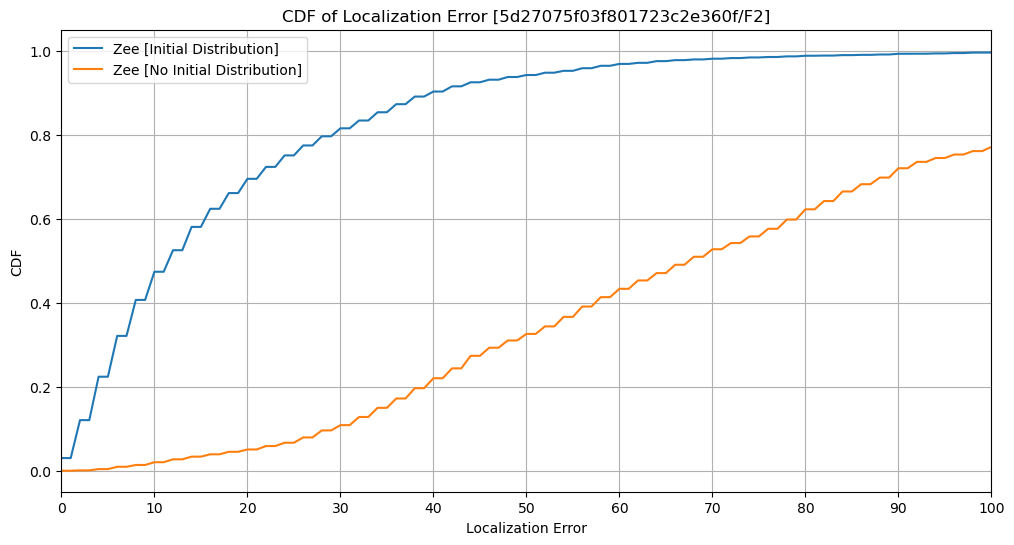

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(sample_cumsum_2, label="Zee [Initial Distribution]")
ax.plot(sample_cumsum_1, label="Zee [No Initial Distribution]")

ax.set_xlim(0, 100)
ax.set_xticks(range(0, 101, 10))

ax.set_title(f"CDF of Localization Error [{site_id}/{floor_id}]")
ax.set_xlabel("Localization Error")
ax.set_ylabel("CDF")
ax.legend()
ax.grid()

# ax.hist(errors_scene_1, bins=50, label="Zee [no prior]", cumulative=True, density=True, histtype="step")
# ax.hist(errors_scene_2, bins=50, label="Zee [with prior]", cumulative=True, density=True, histtype="step")

plt.show()

## Scenario 3: Testing ML model performance

In [50]:
from py_indoor_loc.extract.wifi_fingerprint import read_wifi_location_df_list, extract_fingerprint_df, read_wifi_location_df
from py_indoor_loc.knn.preprocessing import extract_train_test
from py_indoor_loc.knn.experiment import run_knn_regression_experiments

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
def get_track_filepaths(assignment_df: pd.DataFrame, base_data_dir: str) -> list[str]:
  result = []

  for _, row in assignment_df.iterrows():
    file_path = f"{base_data_dir}{row['site_id']}/{row['floor_id']}/{row['track_id']}_wifi_fingerprint.csv"
    if not os.path.exists(file_path):
      print(f"File {file_path} does not exist.")
      continue
    result.append(file_path)
    
  return result

In [53]:
train_tracks, test_tracks = train_test_split(
    site_floor_experiment_tracks[["site_id", "floor_id", "track_id"]].values,
    test_size=0.3,
    shuffle=True,
    random_state=29)


* Ground-truth train dataset + ground-truth test dataset

In [54]:
!mkdir -p ../../data/zee_scene_3

In [55]:
gt_data_dir = Path("../../data/gt_data")
pred_data_dir = Path("../../data/zee_scene_2/train")

In [56]:
def read_wifi_location_df_list(file_path_list: list[str]) -> list[pd.DataFrame]:
  frames = []
  for file_path in file_path_list:
    try:
      frames.append(read_wifi_location_df(file_path))
    except Exception as e:
      print(e)
  return frames

In [57]:
failed = []

try:
  train_files = [
    str(gt_data_dir / site_id / floor_id / (track_id + "_wifi_fingerprint.csv"))
    for site_id, floor_id, track_id in train_tracks
  ]
  test_files = [
    str(gt_data_dir / site_id / floor_id / (track_id + "_wifi_fingerprint.csv"))
    for site_id, floor_id, track_id in test_tracks
  ]

  train_wifi_location_df_list = read_wifi_location_df_list(train_files)
  test_wifi_location_df_list = read_wifi_location_df_list(test_files)

  train_wifi_location_df = pd.concat(train_wifi_location_df_list)
  test_wifi_location_df = pd.concat(test_wifi_location_df_list)

  print(f"Train: n_files={len(train_files)}, n_records={train_wifi_location_df.shape[0]}")
  print(f"Test: n_files={len(test_files)}, n_records={test_wifi_location_df.shape[0]}")

  train_fingerprint_df, train_bssid = extract_fingerprint_df(train_wifi_location_df_list)
  test_fingerprint_df, test_bssid = extract_fingerprint_df(test_wifi_location_df_list)
  X_train, y_train, X_test, y_test, bssid_vector = extract_train_test(
    train_fingerprint_df, train_bssid,
    test_fingerprint_df, test_bssid
  )
  assert len(X_train) == len(y_train)
  assert len(X_test) == len(y_test)

  print(f"The number of train samples: {X_train.shape[0]}")
  print(f"The number of test samples: {X_test.shape[0]}")
  options_min_rss = range(-100, -70, 5)
  options_metric = ["l1", "l2", "cosine"]
  options_n_neighbors = [1, 2, 4, 8]

  results = run_knn_regression_experiments(
    X_train,
    y_train,
    X_test,
    y_test,
    options_metric=options_metric,
    options_n_neighbors=options_n_neighbors,
    options_min_rss=options_min_rss
  )
  result_df = pd.DataFrame(results)
  result_df.to_csv(os.path.join("../../data/zee_scene_3/", f"gt_{site_id}_{floor_id}.csv"), index=False)

except Exception as e:
  print(f"Failed to run kNN experiment for {site_id}/{floor_id}, caused by {type(e)}: {str(e)}")
  failed.append((site_id, floor_id))


[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F2/5de0cd4fbbb32e0006603cdb_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F2/5de0a58bbbb32e0006603c93_wifi_fingerprint.csv'
Train: n_files=113, n_records=966823
Test: n_files=49, n_records=331303
The number of train samples: 3489
The number of test samples: 1219


100%|██████████| 72/72 [05:47<00:00,  4.82s/it]


* Passive crowdsourced train dataset + ground-truth test dataset

In [58]:
failed = []

try:
  train_files = [
    str(pred_data_dir / site_id / floor_id / (track_id + "_wifi_fingerprint.csv"))
    for site_id, floor_id, track_id in train_tracks
  ]
  test_files = [
    str(gt_data_dir / site_id / floor_id / (track_id + "_wifi_fingerprint.csv"))
    for site_id, floor_id, track_id in test_tracks
  ]

  train_wifi_location_df_list = read_wifi_location_df_list(train_files)
  test_wifi_location_df_list = read_wifi_location_df_list(test_files)

  train_wifi_location_df = pd.concat(train_wifi_location_df_list)
  test_wifi_location_df = pd.concat(test_wifi_location_df_list)

  print(f"Train: n_files={len(train_files)}, n_records={train_wifi_location_df.shape[0]}")
  print(f"Test: n_files={len(test_files)}, n_records={test_wifi_location_df.shape[0]}")

  train_fingerprint_df, train_bssid = extract_fingerprint_df(train_wifi_location_df_list)
  test_fingerprint_df, test_bssid = extract_fingerprint_df(test_wifi_location_df_list)
  X_train, y_train, X_test, y_test, bssid_vector = extract_train_test(
    train_fingerprint_df, train_bssid,
    test_fingerprint_df, test_bssid
  )
  assert len(X_train) == len(y_train)
  assert len(X_test) == len(y_test)

  print(f"The number of train samples: {X_train.shape[0]}")
  print(f"The number of test samples: {X_test.shape[0]}")
  options_min_rss = range(-100, -70, 5)
  options_metric = ["l1", "l2", "cosine"]
  options_n_neighbors = [1, 2, 4, 8]

  results = run_knn_regression_experiments(
    X_train,
    y_train,
    X_test,
    y_test,
    options_metric=options_metric,
    options_n_neighbors=options_n_neighbors,
    options_min_rss=options_min_rss
  )
  result_df = pd.DataFrame(results)
  result_df.to_csv(os.path.join("../../data/zee_scene_3/", f"pred_{site_id}_{floor_id}.csv"), index=False)

except Exception as e:
  print(f"Failed to run kNN experiment for {site_id}/{floor_id}, caused by {type(e)}: {str(e)}")
  failed.append((site_id, floor_id))


[Errno 2] No such file or directory: '../../data/zee_scene_2/train/5d27075f03f801723c2e360f/F2/5de0cd4fbbb32e0006603cdb_wifi_fingerprint.csv'
[Errno 2] No such file or directory: '../../data/gt_data/5d27075f03f801723c2e360f/F2/5de0a58bbbb32e0006603c93_wifi_fingerprint.csv'
Train: n_files=113, n_records=962487
Test: n_files=49, n_records=331303
The number of train samples: 3495
The number of test samples: 1219


100%|██████████| 72/72 [05:49<00:00,  4.85s/it]


* Some Analysis

In [159]:
result_df = pd.read_csv("../../data/zee_scene_3/gt_5d27075f03f801723c2e360f_F1.csv")

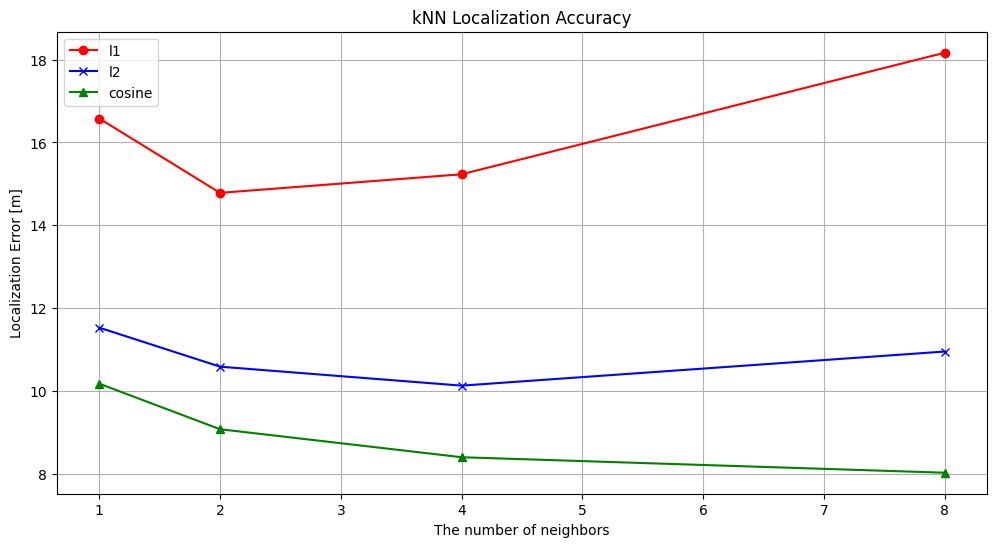

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

markers = ["o", "x", "^"]
colors = ["red", "blue", "green"]

for i, metric in enumerate(["l1", "l2", "cosine"]):
  cut = result_df.loc[(result_df["param_min_rss"] == -85) & (result_df["param_metric"] == metric)].sort_values("param_n_neighbors")
  ax.plot(cut["param_n_neighbors"].values, cut["mean"].values, marker=markers[i], color=colors[i], label=metric)

ax.set_title("kNN Localization Accuracy")
ax.set_xlabel("The number of neighbors")
ax.set_ylabel("Localization Error [m]")
ax.grid()

ax.legend()

plt.show()

In [161]:
result_df[result_df["mean"] == result_df["mean"].min()]

,count,mean,std,p5,p10,p25,p50,p75,p90,p95,param_min_rss,param_metric,param_n_neighbors
47,1601,8.026888,4.753692,1.918296,2.637659,4.653962,7.265261,10.560531,14.393649,17.255609,-85,cosine,8


* Zee

In [162]:
result_df = pd.read_csv("../../data/zee_scene_3/pred_5d27075f03f801723c2e360f_F1.csv")

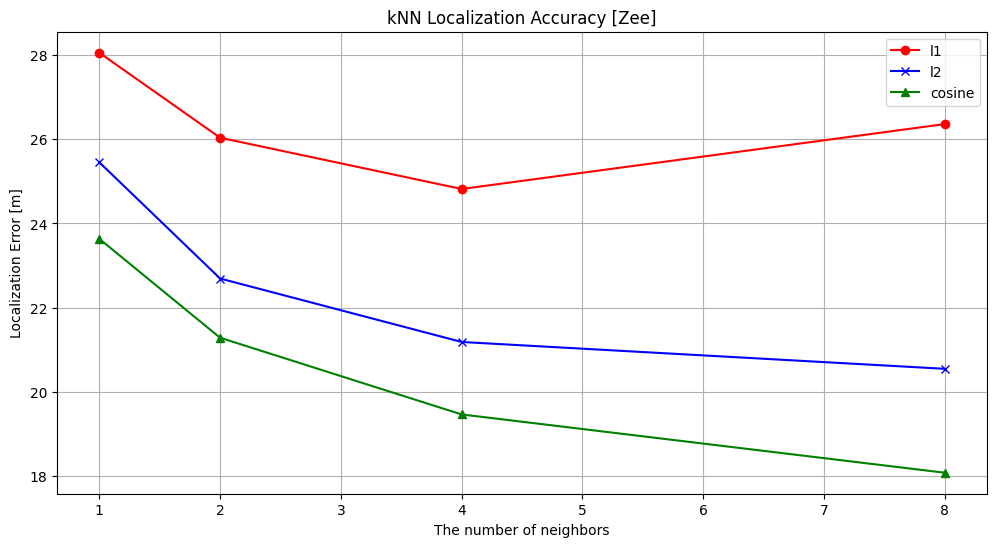

In [163]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

markers = ["o", "x", "^"]
colors = ["red", "blue", "green"]

for i, metric in enumerate(["l1", "l2", "cosine"]):
  cut = result_df.loc[(result_df["param_min_rss"] == -85) & (result_df["param_metric"] == metric)].sort_values("param_n_neighbors")
  ax.plot(cut["param_n_neighbors"].values, cut["mean"].values, marker=markers[i], color=colors[i], label=metric)

ax.set_title("kNN Localization Accuracy [Zee]")
ax.set_xlabel("The number of neighbors")
ax.set_ylabel("Localization Error [m]")
ax.grid()

ax.legend()

plt.show()

In [164]:
result_df[result_df["mean"] == result_df["mean"].min()]

,count,mean,std,p5,p10,p25,p50,p75,p90,p95,param_min_rss,param_metric,param_n_neighbors
47,1601,18.085244,15.854124,3.475347,5.07213,8.301448,13.383495,21.411331,34.962746,57.29432,-85,cosine,8
